<a href="https://colab.research.google.com/github/lukasgehring/deep_learning_group_5/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1

Take the CIFAR-10 dataset. Train a network, which is able to predict for a given input image at least 5 classes. Investigate the robustness by attacking it.

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#seed for pytorch
torch.manual_seed(0)

#seed for python
import random
random.seed(0)

#seed for numpy
np.random.seed(0)

In [ ]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
#device = torch.device("cuda")

In [ ]:
device

device(type='cpu')

In [ ]:
# modified code from: https://medium.com/mlearning-ai/manipulating-pytorch-datasets-c58487ab113f#860e

batch_size = 128

training_data = datasets.CIFAR10(
    root='/data',
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.CIFAR10(
    root='/data',
    train=False,
    download=True,
    transform=ToTensor())

training_data.targets = [d - 2 for d in training_data.targets]
test_data.targets = [d - 2 for d in test_data.targets]

training_idx = np.where((np.asarray(training_data.targets) > -1) & (np.asarray(training_data.targets) < 5))[0]
test_idx = np.where((np.asarray(test_data.targets) > -1) & (np.asarray(test_data.targets) < 5))[0]

training_subset = Subset(training_data, training_idx)
test_subset = Subset(test_data, test_idx)

trainloader = DataLoader(training_subset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('bird', 'cat', 'deer', 'dog', 'frog')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
print(len(test_subset))

5000


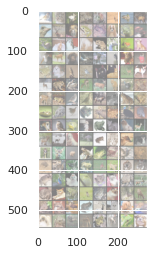

bird  cat   frog  frog  frog  deer  bird  deer  bird  deer  dog   frog  frog  dog   frog  deer  deer  cat   cat   dog   frog  bird  frog  dog   cat   deer  dog   bird  deer  bird  cat   dog   frog  dog   bird  bird  cat   cat   deer  dog   deer  frog  frog  deer  deer  cat   bird  frog  deer  frog  bird  bird  deer  cat   frog  frog  frog  bird  bird  frog  deer  frog  bird  frog  dog   bird  frog  dog   frog  cat   dog   deer  deer  deer  dog   bird  frog  cat   deer  dog   dog   deer  frog  frog  frog  deer  deer  frog  bird  cat   bird  frog  deer  dog   dog   cat   frog  bird  dog   bird  cat   cat   frog  deer  cat   cat   frog  bird  frog  cat   deer  deer  frog  cat   deer  frog  deer  cat   dog   bird  dog   frog  deer  deer  frog  dog   frog  dog  


In [ ]:
# modified code from pytorch.org

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Models

We trained two different models.

The first one has 6 layers with the following test errors:

> Epoch 01 Test Accuracy: 32.68%, Test Loss: 1.537 \\
Epoch 02 Test Accuracy: 38.16%, Test Loss: 1.49 \\
Epoch 03 Test Accuracy: 41.78%, Test Loss: 1.455 \\
Epoch 04 Test Accuracy: 44.28%, Test Loss: 1.434 \\
Epoch 05 Test Accuracy: 44.04%, Test Loss: 1.442 \\
Epoch 06 Test Accuracy: 48.08%, Test Loss: 1.401 \\
Epoch 07 Test Accuracy: 48.74%, Test Loss: 1.4 \\
Epoch 08 Test Accuracy: 48.38%, Test Loss: 1.4 \\
Epoch 09 Test Accuracy: 51.12%, Test Loss: 1.389 \\
Epoch 10 Test Accuracy: 53.72%, Test Loss: 1.362 \\

The second one has 2 layers with the following test errors:


> Epoch 01 Test Accuracy: 53.24%, Test Loss: 1.167 \\
Epoch 02 Test Accuracy: 58.60%, Test Loss: 1.042 \\
Epoch 03 Test Accuracy: 63.08%, Test Loss: 0.951 \\
Epoch 04 Test Accuracy: 64.74%, Test Loss: 0.9254 \\
Epoch 05 Test Accuracy: 67.98%, Test Loss: 0.8516 \\
Epoch 06 Test Accuracy: 64.92%, Test Loss: 0.9289 \\
Epoch 07 Test Accuracy: 68.80%, Test Loss: 0.8425 \\
Epoch 08 Test Accuracy: 67.40%, Test Loss: 0.8517 \\
Epoch 09 Test Accuracy: 68.02%, Test Loss: 0.8694 \\
Epoch 10 Test Accuracy: 68.80%, Test Loss: 0.8444 \\

Because of the better test error, we are using the second model

## 1. Model

In [ ]:
# Architecture based on 'FAWCA: A Flexible-greedy Approach to find Well-tuned CNN Architecture for Image Recognition Problem'

class FAWCA(nn.Module):
    def __init__(self):
        super(FAWCA, self).__init__()
    
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=80, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=80, out_channels=96, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2))
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=64, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2))
        
        self.flatten = nn.Flatten()
        
        self.layer5 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(256, 5),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.flatten(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

## 2. Model

In [ ]:
#batch_size = 64
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
    
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )

        self.fc1 = nn.Linear(in_features=3136, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    

## Training of the model.

In [ ]:
def train_loop(model, data_loader, loss_function, optimizer):
    total_loss = 0.0
    
    batches = len(data_loader)

    for batch, (data, labels) in enumerate(data_loader):

        # send data to device
        data = data.to(device)
        labels = labels.to(device)
        
        # Feed data through network and compute loss.
        prediction = model(data)
        loss = loss_function(prediction, labels)
        total_loss += loss

        # Zero gradients.
        optimizer.zero_grad()
 
        # Perform backpropagation and accumulate gradients.
        loss.backward()
 
        # Update network parameters.
        optimizer.step()

        # print(f"{batch}/{batches}")
    
    return total_loss / len(data_loader)

In [ ]:
def test_loop(data_loader, model, loss_function):
    n_samples = len(data_loader.dataset)
    n_batches = len(data_loader)
    loss, n_correct = 0, 0
 
    with torch.no_grad():
        for data, labels in data_loader:

            # send data to device
            data = data.to(device)
            labels = labels.to(device)

            # Feed data through network and accumulate loss.
            prediction = model(data)
            loss += loss_function(
                prediction, labels
            )
            n_correct += (
                (prediction.argmax(1) == labels)
                .type(torch.float)
                .sum()
                .item()
            )
 
    print(
        f"Test Accuracy: {n_correct / n_samples:.2%}, "
        f"Test Loss: {loss / n_batches:.4}"
    )
    return loss / n_batches

In [ ]:
def train(model, train_data, test_data, optimizer,loss_fn, n_epochs=10):
    train_history = np.zeros(n_epochs)
    test_history = np.zeros(n_epochs)
      
    for t in range(n_epochs):
        print(f"Epoch {t + 1:02}", end=" ", flush=True)
        train_history[t] = train_loop(model, train_data, loss_fn, optimizer)
        test_history[t] = test_loop(test_data, model, loss_fn)
    
    return model, train_history, test_history

In [ ]:
model = ConvNetwork().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn=nn.CrossEntropyLoss()

model, train_history, test_history = train(model, trainloader, testloader, optimizer, loss_fn)

Epoch 01 Test Accuracy: 53.24%, Test Loss: 1.167
Epoch 02 Test Accuracy: 58.60%, Test Loss: 1.042
Epoch 03 Test Accuracy: 63.08%, Test Loss: 0.951
Epoch 04 Test Accuracy: 64.74%, Test Loss: 0.9254
Epoch 05 Test Accuracy: 67.98%, Test Loss: 0.8516
Epoch 06 Test Accuracy: 64.92%, Test Loss: 0.9289
Epoch 07 Test Accuracy: 68.80%, Test Loss: 0.8425
Epoch 08 Test Accuracy: 67.40%, Test Loss: 0.8517
Epoch 09 Test Accuracy: 68.02%, Test Loss: 0.8694
Epoch 10 Test Accuracy: 68.80%, Test Loss: 0.8444


# Attacks to test robustness
## FGSM

In [ ]:
#import
import skimage.data
import skimage.filters
import skimage.io
 
try:
    import seaborn as sns
    sns.set()
except:
    pass

import random
import time
!git clone https://github.com/DSE-MSU/DeepRobust.git
!pip install deeprobust 


fatal: destination path 'DeepRobust' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#FGSM
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.netmodels.CNN import Net
from deeprobust.image.config import attack_params
from deeprobust.image.utils import download_model

def fgsm_untargeted(model,image,label,device):
  
  # load model
  model = model
  model.eval()

  ## load date
  xx = image 
  yy = label.int() 


  F1 = FGSM(model, device = 'cpu')       ### or cuda
  attack_param = {'epsilon' :0.2,
                     'order' : np.inf,
                     'clip_max' : 1,
                     'clip_min' : 0}

  AdvExArray = F1.generate(xx, yy, **attack_param)

  # predict
  predict1 = model(AdvExArray).cpu().detach()
  predict0 = model(xx).cpu().detach()
  
  predict1 = torch.softmax(predict1,dim=-1)#confidence in prediction
  predict0 = torch.softmax(predict0,dim=-1)


  return AdvExArray, predict0, predict1


In [ ]:
#exercise
def image_to_tensor(input_array):
    # Normalize input.
    input_array = input_array - [0.485, 0.456, 0.406]
    input_array = input_array / [0.229, 0.224, 0.225]
 
    # Turn from (width, height, channel) into (batch, channel, width, height) and convert to tensor.
    input_tensor = torch.Tensor((input_array.transpose([2, 0, 1]))[None, ...])
 
    return input_tensor

In [ ]:
#exercise
def tensor_to_image(tensor):
    # Turn from (batch, channel, width, height) tensor into (width, height, channel) array.
    array = tensor[0].detach().numpy().transpose([1, 2, 0])
 
    # Denormalize.
    array = array * [0.229, 0.224, 0.225]
    array = array + [0.485, 0.456, 0.406]
 
    # Clip.
    np.clip(array, 0.0, 1.0, out=array)
 
    return array


In [ ]:
#https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images
#calculating the manhatten norm and zero norm to see how different the attacked image is compared to the original
from scipy.linalg import norm

def calc_distance(img1,img2):
    # read images as 2D arrays (convert to grayscale for simplicity)
    img1 = to_grayscale(img1.astype(float))
    img2 = to_grayscale(img2.astype(float))
    # compare
    n_m, n_0 = compare_images(img1, img2)
    return n_m,n_0

def compare_images(img1, img2):
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))  # Manhattan norm
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    return (m_norm, z_norm)

def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return np.average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng



In [ ]:
#creating a dataframe to save the results
#id of the image, the true labels, the predictions of the original image, type of attack, the predicted label, probailities for the different classes, predicitons for all classes in a list, different norms
import pandas as pd
df = pd.DataFrame(columns=['image','true label','values','attack','predicted label', 'bird', 'cat', 'deer', 'dog', 'frog','predict1','manhatten norm','zero norm'])
df

,image,true label,values,attack,predicted label,bird,cat,deer,dog,frog,predict1,manhatten norm,zero norm


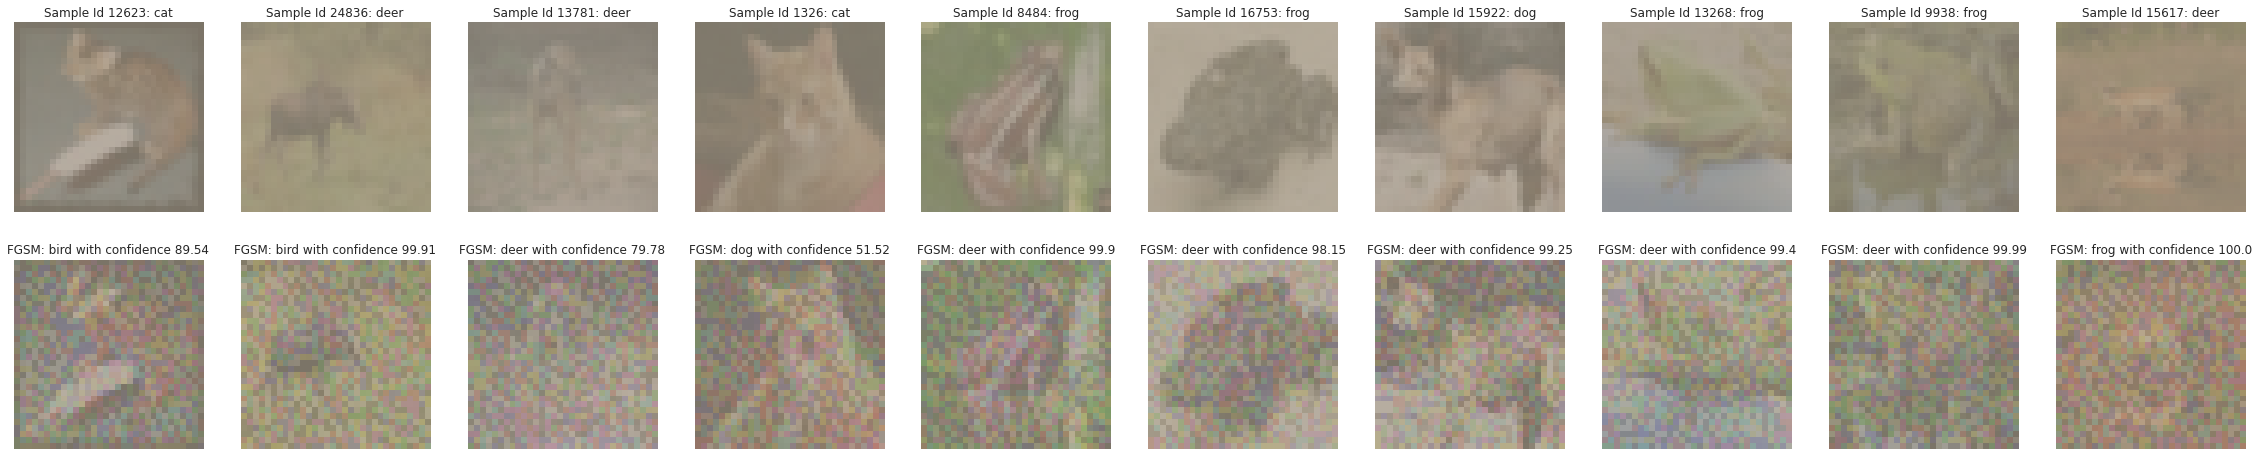

In [ ]:
#fgsm attack for 10 random samples
sample = random.sample(range(len(training_subset)),k=10)
subset = torch.utils.data.Subset(training_subset, sample)
sample_loader = DataLoader(subset , batch_size=1,shuffle=True, num_workers=2) 
n_rows, n_cols = 2,10
i,j,counter=0,0,0
image_figure, image_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

for image , label in sample_loader:
   j=0
   sample_id = sample[i]
   # Prepare figure. 
   img1 = tensor_to_image(image)
   label_idx = int(label[0])
   
   # Show original image.
   ax = image_axes[j][i]
   ax.imshow(img1)
   ax.grid(False)
   ax.axis('off')
   ax.set_title(f'Sample Id {sample_id}: {classes[label_idx]}')
  

   j=1
   #attack image
   img, predict0, predict1 = fgsm_untargeted(model,image,label,device)
   top_idx = int(np.argmax(predict1))
   
   #prepare image
   top_value = predict1.numpy()[0][top_idx]*100
   img = tensor_to_image(img)
   n_m,n_0 = calc_distance(img1,img)

   #add results to DataFrame
   new_row = {'image':sample_id,'true label':classes[label_idx],'values':predict0.tolist()[0],'attack':'fgsm','predicted label':classes[top_idx], 
              'bird':predict1.tolist()[0][0], 'cat':predict1.tolist()[0][1], 'deer':predict1.tolist()[0][2], 'dog':predict1.tolist()[0][3], 'frog':predict1.tolist()[0][4],
              'manhatten norm':n_m,'zero norm':n_0, 'predict1':predict1.tolist()[0]}
   df = df.append(new_row, ignore_index=True)
  
   # Show original image.
   ax = image_axes[j][i]
   ax.imshow(img)
   ax.grid(False)
   ax.axis('off')
   ax.set_title(f'FGSM: {classes[top_idx]} with confidence {round(top_value,2)}')

   i+=1
   
   

In [ ]:
df

,image,true label,values,attack,predicted label,bird,cat,deer,dog,frog,predict1,manhatten norm,zero norm
0,12623,cat,"[0.00983469933271408, 0.288260817527771, 0.002...",fgsm,bird,0.895436,9.784463e-08,2.793399e-02,2.055148e-02,5.607887e-02,"[0.8954355716705322, 9.78446337285277e-08, 0.0...",26708.636383,1024.0
1,24836,deer,"[0.258990615606308, 0.0025318805128335953, 0.7...",fgsm,bird,0.999112,4.084642e-09,1.679351e-04,4.934110e-09,7.197409e-04,"[0.9991123080253601, 4.084642402091276e-09, 0....",40180.254237,1023.0
2,13781,deer,"[0.08934640884399414, 0.0909125953912735, 0.66...",fgsm,deer,0.015972,2.008937e-02,7.977654e-01,2.562204e-03,1.636113e-01,"[0.015971798449754715, 0.020089374855160713, 0...",33093.583300,1024.0
3,1326,cat,"[0.0020584070589393377, 0.583622932434082, 0.0...",fgsm,dog,0.287042,4.095770e-05,8.668733e-02,5.151917e-01,1.110383e-01,"[0.2870417535305023, 4.095770054846071e-05, 0....",31030.331541,1024.0
4,8484,frog,"[0.11765545606613159, 0.011583025567233562, 0....",fgsm,deer,0.000994,5.041120e-08,9.990053e-01,5.847871e-07,3.708905e-10,"[0.000994160887785256, 5.04111987709166e-08, 0...",27056.894912,1024.0
5,16753,frog,"[0.014807380735874176, 0.052743133157491684, 0...",fgsm,deer,0.015934,6.553502e-04,9.814920e-01,1.480275e-03,4.385767e-04,"[0.015933800488710403, 0.0006553502171300352, ...",29279.051135,1024.0
6,15922,dog,"[0.0005859689554199576, 0.5666813850402832, 0....",fgsm,deer,0.000068,5.221603e-03,9.924717e-01,5.799288e-10,2.238608e-03,"[6.807516911067069e-05, 0.0052216025069355965,...",27421.130632,1024.0
7,13268,frog,"[0.08529059588909149, 0.007872361689805984, 0....",fgsm,deer,0.005920,1.061000e-05,9.940240e-01,6.080560e-07,4.520490e-05,"[0.005919657647609711, 1.0610001481836662e-05,...",29374.973709,1024.0
8,9938,frog,"[0.09620053321123123, 0.03472863882780075, 0.1...",fgsm,deer,0.000027,3.413372e-06,9.999490e-01,4.101375e-07,2.051626e-05,"[2.6690016966313124e-05, 3.4133715871575987e-0...",35798.709750,1024.0
9,15617,deer,"[0.024229276925325394, 0.08032801747322083, 0....",fgsm,frog,0.000004,3.335615e-06,1.945797e-07,1.018318e-07,9.999923e-01,"[4.061904746777145e-06, 3.3356154744978994e-06...",32400.490192,1024.0


In [ ]:
df.to_csv('fgsm.csv') # save results in a csv

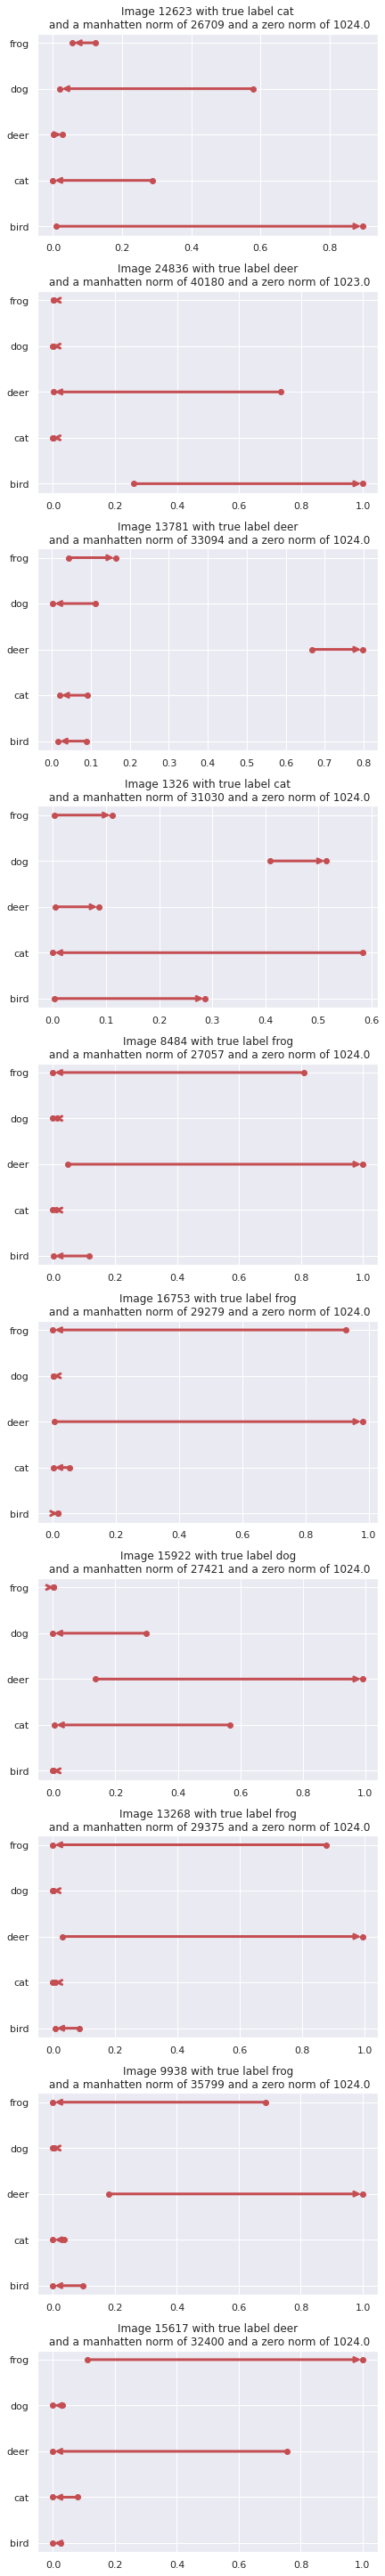

In [ ]:
#show the change of probailities after the attack of image of index j
import matplotlib.pyplot as plt
import numpy as np

n_rows=10
j=0#iundex of attacked image
image_figure, image_axes = plt.subplots(n_rows, 1, figsize=(6, n_rows * 4))
# using padding

for j in range(0,10):
  x = np.linspace(0, 1, 10)
  for i in range(0, 5):

      x = [classes[i],classes[i]]
      y = [df['values'][j][i],df.predict1[j][i]]

      ax = image_axes[j]
      ax.set_title('Image '+str(df.image[j])+ ' with true label '+df['true label'][j]+'\n and a manhatten norm of '+ str(round(df['manhatten norm'][j]))+ ' and a zero norm of '+ str(df['zero norm'][j]))
      ax.plot(y,x,'ro-')
      ax.annotate("", xy=(y[0], x[0]), xytext=(y[1],x[1]), arrowprops=dict(arrowstyle='<-',color='r',lw=3)) #annotate an arrow to show wether a probability increased or descreased
      
image_figure.tight_layout(pad=0, w_pad=0, h_pad=1.0) 
plt.show()